In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
param = pybamm.LithiumIonParameters()
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
Cn
Cp

5.795692012196613

## Initialize model at full charge to 4.1V

In [3]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
parameter_values.update(
    {
        "Exchange-current density for plating [A.m-2]": 0.001,
        "Initial plated lithium concentration [mol.m-3]": 0,
        "Lithium metal partial molar volume [m3.mol-1]": 1.3e-5,
        "SEI kinetic rate constant [m.s-1]": 1e-15,
        "SEI resistivity [Ohm.m]": 0,
    },
)
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        "SEI film resistance": "none",
        "lithium plating": "irreversible",
    }
)

In [4]:
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = spm.param

Vmin = 3.0
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
)
print(esoh_sol["x_100"].data[0])
print(esoh_sol["y_100"].data[0])

0.8334162315444247
0.03350230659015566


## One cycle

In [5]:
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol["x_100"].data[0] * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol["y_100"].data[0] * c_p_max,
    }
)
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

In [6]:
spm_sol.plot(["Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=3.148682032825511, step=0.03148682032825511)…

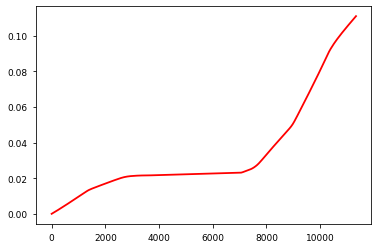

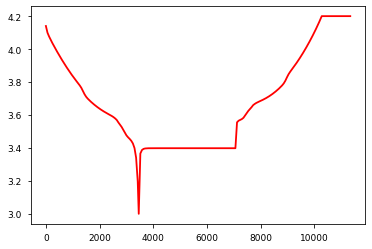

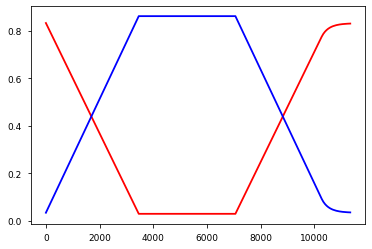

In [7]:
plt.plot(spm_sol["Time [s]"].data, spm_sol["Loss of Lithium Inventory [%]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Terminal voltage [V]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Negative electrode SOC"].data)
plt.plot(spm_sol["Time [s]"].data, spm_sol["Positive electrode SOC"].data)

In [8]:
lli = spm_sol["Loss of Lithium Inventory [%]"].data
lli_one_cycle = lli[-1] - lli[0]

## Several cycles

In [23]:
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 300,
termination="80% capacity"
)
sim_100 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
spm_sol_100 = sim_100.solve()

2021-03-21 21:58:00,302 - [NOTICE] simulation.solve(701): Cycle 1/300 (425.302 ms elapsed) --------------------
2021-03-21 21:58:00,302 - [NOTICE] simulation.solve(731): Cycle 1/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:00,416 - [NOTICE] simulation.solve(731): Cycle 1/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:00,501 - [NOTICE] simulation.solve(731): Cycle 1/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:00,614 - [NOTICE] simulation.solve(731): Cycle 1/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:00,940 - [NOTICE] simulation.solve(807): Capacity is now 4.936 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:00,941 - [NOTICE] simulation.solve(701): Cycle 2/300 (1.064 s elapsed) --------------------
2021-03-21 21:58:00,941 - [NOTICE] simulation.solve(731): Cycle 2/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:00,997 - [NOTICE] simulation.solve(731): Cycle 2/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:01,040 - [NOTI

2021-03-21 21:58:03,535 - [NOTICE] simulation.solve(731): Cycle 13/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:03,609 - [NOTICE] simulation.solve(807): Capacity is now 4.869 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:03,610 - [NOTICE] simulation.solve(701): Cycle 14/300 (3.734 s elapsed) --------------------
2021-03-21 21:58:03,610 - [NOTICE] simulation.solve(731): Cycle 14/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:03,661 - [NOTICE] simulation.solve(731): Cycle 14/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:03,696 - [NOTICE] simulation.solve(731): Cycle 14/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:03,735 - [NOTICE] simulation.solve(731): Cycle 14/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:03,801 - [NOTICE] simulation.solve(807): Capacity is now 4.864 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:03,802 - [NOTICE] simulation.solve(701): Cycle 15/300 (3.926 s elapsed) --------------------

2021-03-21 21:58:05,833 - [NOTICE] simulation.solve(731): Cycle 26/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:05,885 - [NOTICE] simulation.solve(731): Cycle 26/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:05,925 - [NOTICE] simulation.solve(731): Cycle 26/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:05,973 - [NOTICE] simulation.solve(731): Cycle 26/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:06,048 - [NOTICE] simulation.solve(807): Capacity is now 4.799 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:06,049 - [NOTICE] simulation.solve(701): Cycle 27/300 (6.172 s elapsed) --------------------
2021-03-21 21:58:06,049 - [NOTICE] simulation.solve(731): Cycle 27/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:06,095 - [NOTICE] simulation.solve(731): Cycle 27/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:06,131 - [NOTICE] simulation.solve(731): Cycle 27/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:06,172 - [NOT

2021-03-21 21:58:08,337 - [NOTICE] simulation.solve(731): Cycle 38/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:08,406 - [NOTICE] simulation.solve(807): Capacity is now 4.735 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:08,407 - [NOTICE] simulation.solve(701): Cycle 39/300 (8.531 s elapsed) --------------------
2021-03-21 21:58:08,408 - [NOTICE] simulation.solve(731): Cycle 39/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:08,458 - [NOTICE] simulation.solve(731): Cycle 39/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:08,499 - [NOTICE] simulation.solve(731): Cycle 39/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:08,548 - [NOTICE] simulation.solve(731): Cycle 39/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:08,624 - [NOTICE] simulation.solve(807): Capacity is now 4.729 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:08,625 - [NOTICE] simulation.solve(701): Cycle 40/300 (8.748 s elapsed) --------------------

2021-03-21 21:58:10,640 - [NOTICE] simulation.solve(731): Cycle 51/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:10,685 - [NOTICE] simulation.solve(731): Cycle 51/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:10,718 - [NOTICE] simulation.solve(731): Cycle 51/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:10,758 - [NOTICE] simulation.solve(731): Cycle 51/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:10,822 - [NOTICE] simulation.solve(807): Capacity is now 4.667 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:10,823 - [NOTICE] simulation.solve(701): Cycle 52/300 (10.946 s elapsed) --------------------
2021-03-21 21:58:10,823 - [NOTICE] simulation.solve(731): Cycle 52/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:10,875 - [NOTICE] simulation.solve(731): Cycle 52/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:10,914 - [NOTICE] simulation.solve(731): Cycle 52/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:10,952 - [NO

2021-03-21 21:58:13,110 - [NOTICE] simulation.solve(731): Cycle 63/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:13,204 - [NOTICE] simulation.solve(807): Capacity is now 4.605 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:13,206 - [NOTICE] simulation.solve(701): Cycle 64/300 (13.330 s elapsed) --------------------
2021-03-21 21:58:13,209 - [NOTICE] simulation.solve(731): Cycle 64/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:13,267 - [NOTICE] simulation.solve(731): Cycle 64/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:13,311 - [NOTICE] simulation.solve(731): Cycle 64/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:13,367 - [NOTICE] simulation.solve(731): Cycle 64/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:13,450 - [NOTICE] simulation.solve(807): Capacity is now 4.600 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:13,450 - [NOTICE] simulation.solve(701): Cycle 65/300 (13.574 s elapsed) ------------------

2021-03-21 21:58:15,587 - [NOTICE] simulation.solve(731): Cycle 76/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:15,628 - [NOTICE] simulation.solve(731): Cycle 76/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:15,660 - [NOTICE] simulation.solve(731): Cycle 76/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:15,700 - [NOTICE] simulation.solve(731): Cycle 76/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:15,757 - [NOTICE] simulation.solve(807): Capacity is now 4.540 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:15,757 - [NOTICE] simulation.solve(701): Cycle 77/300 (15.881 s elapsed) --------------------
2021-03-21 21:58:15,758 - [NOTICE] simulation.solve(731): Cycle 77/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:15,798 - [NOTICE] simulation.solve(731): Cycle 77/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:15,831 - [NOTICE] simulation.solve(731): Cycle 77/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:15,882 - [NO

2021-03-21 21:58:17,937 - [NOTICE] simulation.solve(731): Cycle 88/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:17,999 - [NOTICE] simulation.solve(807): Capacity is now 4.481 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:18,000 - [NOTICE] simulation.solve(701): Cycle 89/300 (18.123 s elapsed) --------------------
2021-03-21 21:58:18,000 - [NOTICE] simulation.solve(731): Cycle 89/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:18,040 - [NOTICE] simulation.solve(731): Cycle 89/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:18,074 - [NOTICE] simulation.solve(731): Cycle 89/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:18,114 - [NOTICE] simulation.solve(731): Cycle 89/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:18,175 - [NOTICE] simulation.solve(807): Capacity is now 4.476 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:18,176 - [NOTICE] simulation.solve(701): Cycle 90/300 (18.300 s elapsed) ------------------

2021-03-21 21:58:20,446 - [NOTICE] simulation.solve(731): Cycle 101/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:20,486 - [NOTICE] simulation.solve(731): Cycle 101/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:20,519 - [NOTICE] simulation.solve(731): Cycle 101/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:20,556 - [NOTICE] simulation.solve(731): Cycle 101/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:20,622 - [NOTICE] simulation.solve(807): Capacity is now 4.418 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:20,623 - [NOTICE] simulation.solve(701): Cycle 102/300 (20.746 s elapsed) --------------------
2021-03-21 21:58:20,623 - [NOTICE] simulation.solve(731): Cycle 102/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:20,671 - [NOTICE] simulation.solve(731): Cycle 102/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:20,712 - [NOTICE] simulation.solve(731): Cycle 102/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:20,7

2021-03-21 21:58:22,846 - [NOTICE] simulation.solve(731): Cycle 113/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:22,905 - [NOTICE] simulation.solve(807): Capacity is now 4.361 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:22,906 - [NOTICE] simulation.solve(701): Cycle 114/300 (23.029 s elapsed) --------------------
2021-03-21 21:58:22,906 - [NOTICE] simulation.solve(731): Cycle 114/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:22,947 - [NOTICE] simulation.solve(731): Cycle 114/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:22,996 - [NOTICE] simulation.solve(731): Cycle 114/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:23,049 - [NOTICE] simulation.solve(731): Cycle 114/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:23,123 - [NOTICE] simulation.solve(807): Capacity is now 4.357 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:23,123 - [NOTICE] simulation.solve(701): Cycle 115/300 (23.247 s elapsed) -----------

2021-03-21 21:58:25,801 - [NOTICE] simulation.solve(731): Cycle 126/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:25,846 - [NOTICE] simulation.solve(731): Cycle 126/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:25,885 - [NOTICE] simulation.solve(731): Cycle 126/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:25,928 - [NOTICE] simulation.solve(731): Cycle 126/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:25,999 - [NOTICE] simulation.solve(807): Capacity is now 4.301 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:25,999 - [NOTICE] simulation.solve(701): Cycle 127/300 (26.123 s elapsed) --------------------
2021-03-21 21:58:26,000 - [NOTICE] simulation.solve(731): Cycle 127/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:26,048 - [NOTICE] simulation.solve(731): Cycle 127/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:26,089 - [NOTICE] simulation.solve(731): Cycle 127/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:26,1

2021-03-21 21:58:28,281 - [NOTICE] simulation.solve(731): Cycle 138/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:28,354 - [NOTICE] simulation.solve(807): Capacity is now 4.246 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:28,355 - [NOTICE] simulation.solve(701): Cycle 139/300 (28.479 s elapsed) --------------------
2021-03-21 21:58:28,356 - [NOTICE] simulation.solve(731): Cycle 139/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:28,397 - [NOTICE] simulation.solve(731): Cycle 139/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:28,434 - [NOTICE] simulation.solve(731): Cycle 139/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:28,472 - [NOTICE] simulation.solve(731): Cycle 139/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:28,530 - [NOTICE] simulation.solve(807): Capacity is now 4.242 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:28,531 - [NOTICE] simulation.solve(701): Cycle 140/300 (28.655 s elapsed) -----------

2021-03-21 21:58:30,795 - [NOTICE] simulation.solve(731): Cycle 151/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:30,851 - [NOTICE] simulation.solve(731): Cycle 151/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:30,904 - [NOTICE] simulation.solve(731): Cycle 151/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:30,969 - [NOTICE] simulation.solve(731): Cycle 151/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:31,053 - [NOTICE] simulation.solve(807): Capacity is now 4.188 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:31,054 - [NOTICE] simulation.solve(701): Cycle 152/300 (31.178 s elapsed) --------------------
2021-03-21 21:58:31,055 - [NOTICE] simulation.solve(731): Cycle 152/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:31,112 - [NOTICE] simulation.solve(731): Cycle 152/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:31,155 - [NOTICE] simulation.solve(731): Cycle 152/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:31,2

2021-03-21 21:58:33,643 - [NOTICE] simulation.solve(731): Cycle 163/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:33,716 - [NOTICE] simulation.solve(807): Capacity is now 4.136 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:33,717 - [NOTICE] simulation.solve(701): Cycle 164/300 (33.840 s elapsed) --------------------
2021-03-21 21:58:33,717 - [NOTICE] simulation.solve(731): Cycle 164/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:33,782 - [NOTICE] simulation.solve(731): Cycle 164/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:33,838 - [NOTICE] simulation.solve(731): Cycle 164/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:33,897 - [NOTICE] simulation.solve(731): Cycle 164/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:33,988 - [NOTICE] simulation.solve(807): Capacity is now 4.131 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:33,989 - [NOTICE] simulation.solve(701): Cycle 165/300 (34.113 s elapsed) -----------

2021-03-21 21:58:36,373 - [NOTICE] simulation.solve(731): Cycle 176/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:36,417 - [NOTICE] simulation.solve(731): Cycle 176/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:36,459 - [NOTICE] simulation.solve(731): Cycle 176/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:36,505 - [NOTICE] simulation.solve(731): Cycle 176/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:36,578 - [NOTICE] simulation.solve(807): Capacity is now 4.080 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:36,579 - [NOTICE] simulation.solve(701): Cycle 177/300 (36.703 s elapsed) --------------------
2021-03-21 21:58:36,579 - [NOTICE] simulation.solve(731): Cycle 177/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:36,628 - [NOTICE] simulation.solve(731): Cycle 177/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:36,676 - [NOTICE] simulation.solve(731): Cycle 177/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:36,7

2021-03-21 21:58:39,362 - [NOTICE] simulation.solve(731): Cycle 188/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:39,454 - [NOTICE] simulation.solve(807): Capacity is now 4.029 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:39,455 - [NOTICE] simulation.solve(701): Cycle 189/300 (39.579 s elapsed) --------------------
2021-03-21 21:58:39,456 - [NOTICE] simulation.solve(731): Cycle 189/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:39,510 - [NOTICE] simulation.solve(731): Cycle 189/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:39,562 - [NOTICE] simulation.solve(731): Cycle 189/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:39,614 - [NOTICE] simulation.solve(731): Cycle 189/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:39,686 - [NOTICE] simulation.solve(807): Capacity is now 4.025 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:39,687 - [NOTICE] simulation.solve(701): Cycle 190/300 (39.811 s elapsed) -----------

2021-03-21 21:58:42,363 - [NOTICE] simulation.solve(731): Cycle 201/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:42,420 - [NOTICE] simulation.solve(731): Cycle 201/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:42,473 - [NOTICE] simulation.solve(731): Cycle 201/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:42,524 - [NOTICE] simulation.solve(731): Cycle 201/300, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:58:42,615 - [NOTICE] simulation.solve(807): Capacity is now 3.975 Ah (originally 4.936 Ah, will stop at 3.949 Ah)
2021-03-21 21:58:42,615 - [NOTICE] simulation.solve(701): Cycle 202/300 (42.739 s elapsed) --------------------
2021-03-21 21:58:42,616 - [NOTICE] simulation.solve(731): Cycle 202/300, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:58:42,668 - [NOTICE] simulation.solve(731): Cycle 202/300, step 2/4: Rest for 1 hour
2021-03-21 21:58:42,717 - [NOTICE] simulation.solve(731): Cycle 202/300, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:58:42,7

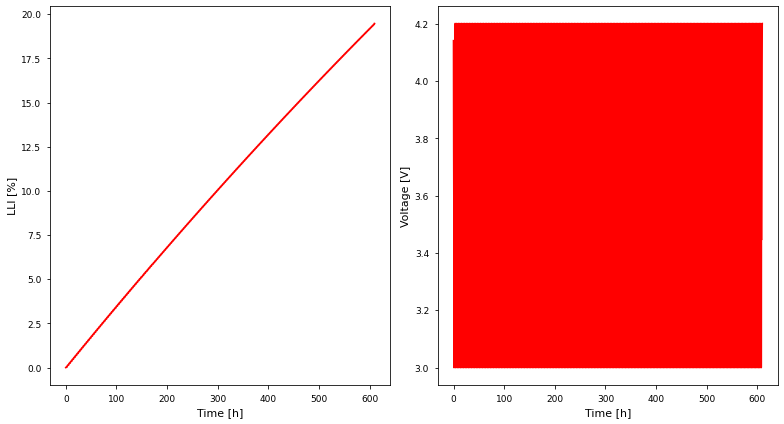

In [24]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
OUTPUT_DIR = "/Users/vsulzer/Google Drive/PCL_Sulzer/"
fig.savefig(OUTPUT_DIR + "100_cycles.eps", dpi=1000)

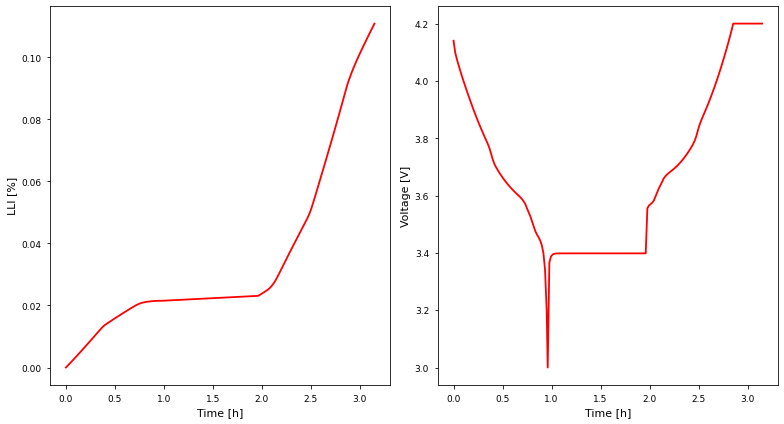

In [25]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "first_cycle.eps", dpi=1000)

In [26]:
lli_100 = spm_sol_100["Loss of Lithium Inventory [%]"].data
lli_100_cycles = lli_100[-1] - lli_100[0]

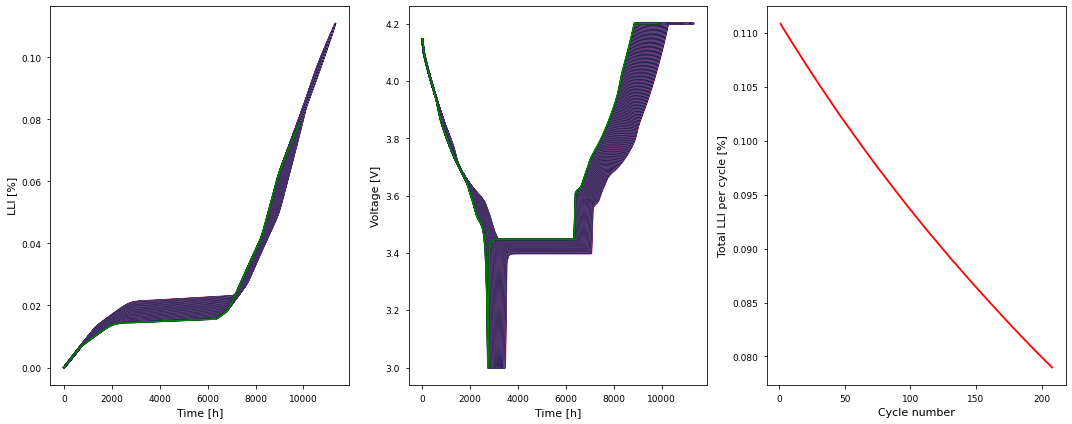

In [27]:

fig, ax = plt.subplots(1,3,figsize=(15,6))

all_lli = []
for cycle in spm_sol_100.cycles:
    t = cycle["Time [s]"].data
    lli = cycle["Loss of Lithium Inventory [%]"].data
    V = cycle["Terminal voltage [V]"].data

    ax[0].plot(t - t[0], lli-lli[0])
    ax[1].plot(t-t[0], V)
    
    all_lli.append(lli[-1]-lli[0])

ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")    
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

ax[2].plot(range(1, len(all_lli)+1), all_lli)
ax[2].set_xlabel("Cycle number")
ax[2].set_ylabel("Total LLI per cycle [%]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "cycles_comparison.eps", dpi=1000)

### eSOH parameters


In [28]:
len(spm_sol_100.summary_variables.items())

71

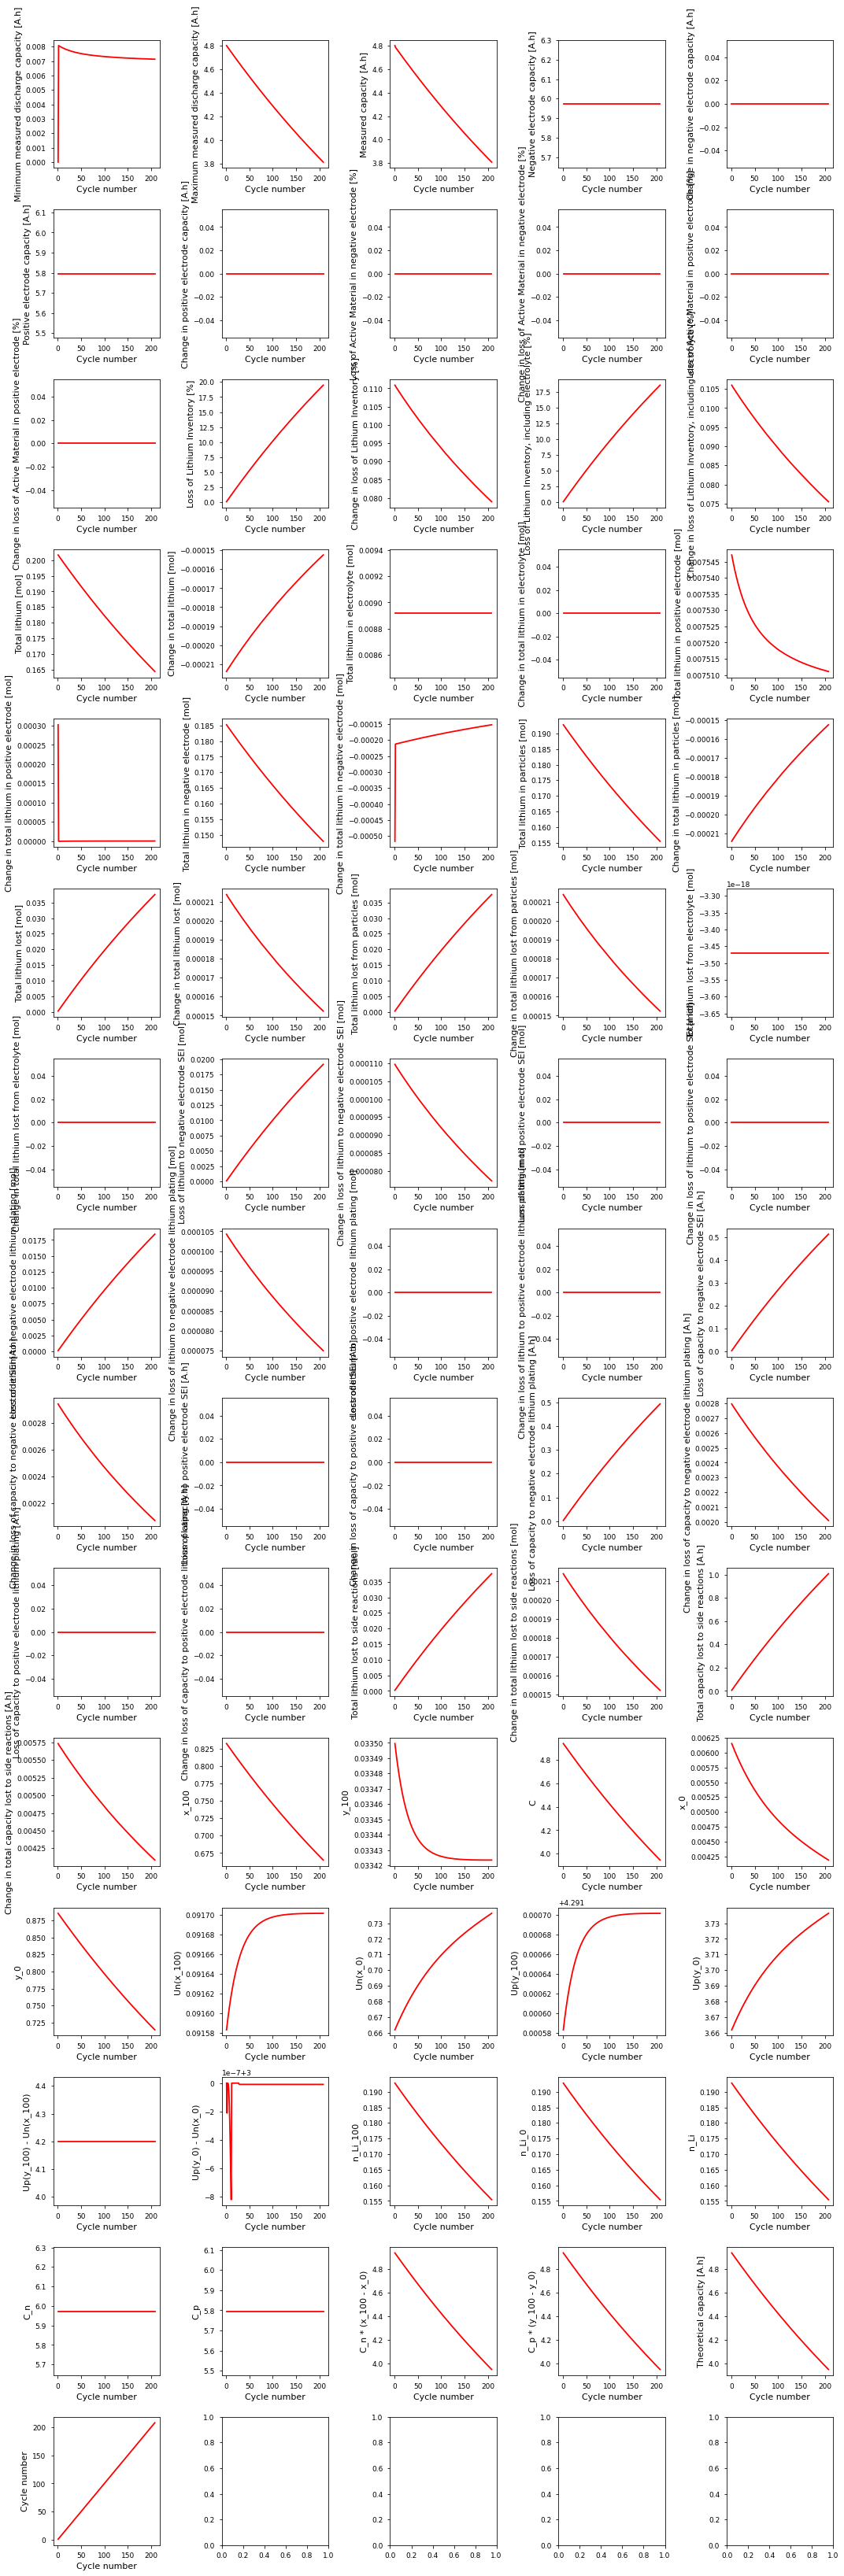

In [29]:
fig, axes = plt.subplots(15,5,figsize=(15,45))

for k, (name,val) in enumerate(spm_sol_100.summary_variables.items()):
    ax = axes.flat[k]
    ax.plot(spm_sol_100.summary_variables["Cycle number"],val)
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(name)

# axes.flat[4].plot(range(1,101), all_nLi)
# axes.flat[4].set_xlabel("Cycle number")
# axes.flat[4].set_ylabel("n_Li")
# axes.flat[-1].plot(range(1,101), all_C)
# axes.flat[-1].set_xlabel("Cycle number")
# axes.flat[-1].set_ylabel("C")
# axes.flat[-1].set_ylim([2,5])
# axes.flat[-2].set_ylim([2,5])

fig.tight_layout()

## Accelerated simulations algorithm

### Constant extrapolation

Solve for 1 cycle

In [30]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

2021-03-21 21:59:23,118 - [NOTICE] simulation.solve(701): Cycle 1/1 (35.989 ms elapsed) --------------------
2021-03-21 21:59:23,119 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:23,233 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:23,324 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:59:23,437 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:59:23,778 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 696.211 ms


Check how well extrapolating 1 cycle does

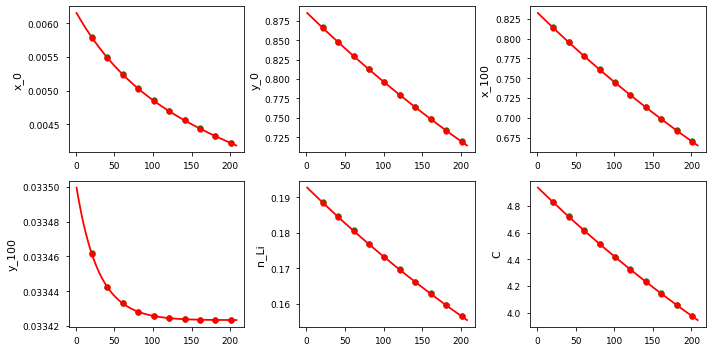

In [31]:
n_cycles_step = 20
long_sol = spm_sol_100
cycle = 0

esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, ax = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax.flat[k].plot(long_sol.summary_variables["Cycle number"], long_sol.summary_variables[name])
    ax.flat[k].set_ylabel(name)

while cycle < len(long_sol.cycles)-n_cycles_step:
    n_Li_cycle = long_sol.cycles[cycle]["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[0] - n_Li_cycle[-1]
    
    n_Li = n_Li_cycle_init - delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    
    cycle += n_cycles_step
    for k, name in enumerate(esoh_vars):
        ax.flat[k].scatter(cycle+1,esoh_sol[name].data[0],color="g")
        ax.flat[k].scatter(cycle+1,long_sol.summary_variables[name][cycle],color="r")
        
fig.tight_layout()

Use extrapolation to initialize next simulation

In [32]:
n_cycles_step = 20
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_acc = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_acc = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_acc.solve()
    
    n_Li_cycle = sol["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[-1] - n_Li_cycle[0]
    
    n_Li = n_Li_cycle_init + delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            first = sim_acc.solution.first_state[var.name].data
            last = sim_acc.solution.last_state[var.name].data
            ics[var.name] = first + (last - first) * n_cycles_step
#             ics[var.name] = sim_acc.solution[var.name].data
    sim_acc.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc.append(sol)
    cycle += n_cycles_step

0


2021-03-21 21:59:28,856 - [NOTICE] simulation.solve(701): Cycle 1/1 (31.049 ms elapsed) --------------------
2021-03-21 21:59:28,857 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:28,991 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:29,092 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:59:29,214 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:59:29,546 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 720.732 ms
2021-03-21 21:59:29,600 - [NOTICE] simulation.solve(701): Cycle 1/1 (35.561 ms elapsed) --------------------
2021-03-21 21:59:29,601 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:29,729 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:29,779 - [NOTICE] simulation.solve(731): Cycle 1/1, s

20


2021-03-21 21:59:29,839 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:59:30,095 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 530.656 ms
2021-03-21 21:59:30,147 - [NOTICE] simulation.solve(701): Cycle 1/1 (36.413 ms elapsed) --------------------
2021-03-21 21:59:30,148 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:30,255 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:30,295 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:59:30,342 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


40


2021-03-21 21:59:30,571 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 460.903 ms
2021-03-21 21:59:30,621 - [NOTICE] simulation.solve(701): Cycle 1/1 (34.969 ms elapsed) --------------------
2021-03-21 21:59:30,621 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:30,720 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:30,760 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:59:30,806 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


60


2021-03-21 21:59:31,038 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 452.459 ms
2021-03-21 21:59:31,091 - [NOTICE] simulation.solve(701): Cycle 1/1 (37.961 ms elapsed) --------------------
2021-03-21 21:59:31,092 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:31,196 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:31,237 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:59:31,285 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


80


2021-03-21 21:59:31,496 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 442.677 ms
2021-03-21 21:59:31,540 - [NOTICE] simulation.solve(701): Cycle 1/1 (32.753 ms elapsed) --------------------
2021-03-21 21:59:31,541 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:31,632 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:31,673 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:59:31,717 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


100


2021-03-21 21:59:31,930 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 422.521 ms
2021-03-21 21:59:31,981 - [NOTICE] simulation.solve(701): Cycle 1/1 (37.165 ms elapsed) --------------------
2021-03-21 21:59:31,981 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:32,070 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:32,107 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:59:32,149 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


120


2021-03-21 21:59:32,370 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 426.750 ms
2021-03-21 21:59:32,420 - [NOTICE] simulation.solve(701): Cycle 1/1 (36.349 ms elapsed) --------------------
2021-03-21 21:59:32,421 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:32,519 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:32,559 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:59:32,601 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


140


2021-03-21 21:59:32,792 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 408.166 ms
2021-03-21 21:59:32,839 - [NOTICE] simulation.solve(701): Cycle 1/1 (33.651 ms elapsed) --------------------
2021-03-21 21:59:32,840 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:32,931 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:32,967 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:59:33,008 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


160


2021-03-21 21:59:33,195 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 389.996 ms
2021-03-21 21:59:33,240 - [NOTICE] simulation.solve(701): Cycle 1/1 (33.119 ms elapsed) --------------------
2021-03-21 21:59:33,240 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:33,332 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:33,369 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:59:33,409 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50


180


2021-03-21 21:59:33,608 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 402.033 ms
2021-03-21 21:59:33,650 - [NOTICE] simulation.solve(701): Cycle 1/1 (28.413 ms elapsed) --------------------
2021-03-21 21:59:33,651 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:59:33,751 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:59:33,815 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V


200


2021-03-21 21:59:33,866 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:59:34,140 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 518.380 ms


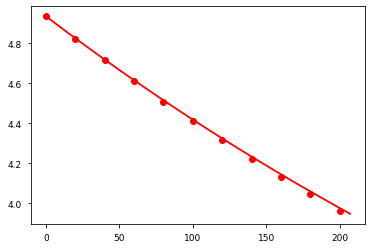

In [33]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]

fig, ax = plt.subplots()
ax.plot(cycle_nums, n_Li_acc, "ro")
ax.plot(long_sol.summary_variables["C"])
# for k, sol in enumerate(sol_acc):
#     print(sol.summary_variables["n_Li"])
#     print(spm_sol_100.summary_variables["n_Li"][k * n_cycles_step])

2021-03-21 21:59:34,592 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
2021-03-21 21:59:34,593 - [WARNING] backend_ps._is_transparent(734): The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


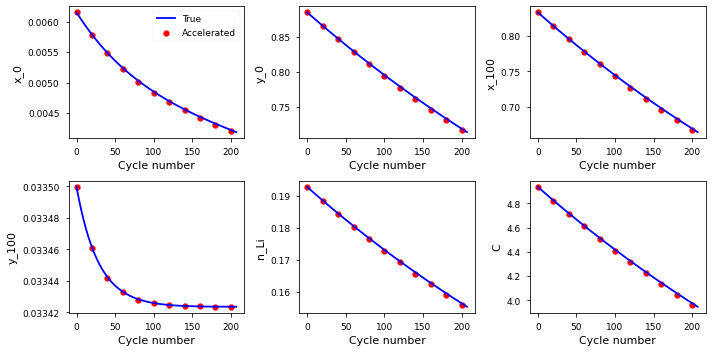

In [34]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name] for sol in sol_acc],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()
fig.savefig(OUTPUT_DIR + "accelerated_sims.eps", dpi=1000)

### Time upscaling

In [22]:
n_cycles_step = 20
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_upscale = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_upscale = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_upscale.solve()
    
    for var in sol.all_models[0].initial_conditions:
        first = sim_upscale.solution.first_state[var.name].data
        last = sim_upscale.solution.last_state[var.name].data
        ics[var.name] = first + (last - first) * n_cycles_step
    sim_upscale.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)
    print(ics['X-averaged positive particle concentration'])
    cycle_nums.append(cycle)
    sol_upscale.append(sol)
    cycle += n_cycles_step

0


2021-03-21 21:57:28,469 - [NOTICE] simulation.solve(701): Cycle 1/1 (30.214 ms elapsed) --------------------
2021-03-21 21:57:28,469 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:57:28,576 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:57:28,683 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-03-21 21:57:28,819 - [NOTICE] simulation.solve(731): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-03-21 21:57:29,127 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 688.447 ms
2021-03-21 21:57:29,163 - [NOTICE] simulation.solve(701): Cycle 1/1 (31.823 ms elapsed) --------------------
2021-03-21 21:57:29,164 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:57:29,255 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 21:57:29,296 - [NOTICE] simulation.solve(731): Cycle 1/1, s

[[0.08297176]
 [0.0828995 ]
 [0.08271909]
 [0.08243921]
 [0.08206287]
 [0.08159221]
 [0.08102928]
 [0.0803763 ]
 [0.07963569]
 [0.07881015]
 [0.07790261]
 [0.0769163 ]
 [0.07585466]
 [0.07472139]
 [0.07352044]
 [0.07225593]
 [0.07093222]
 [0.06955382]
 [0.06812542]
 [0.06665184]
 [0.06513804]
 [0.06358907]
 [0.06201008]
 [0.06040626]
 [0.05878286]
 [0.05714514]
 [0.05549838]
 [0.0538478 ]
 [0.05219862]
 [0.05055597]]
20


2021-03-21 21:57:29,561 - [NOTICE] simulation.solve(823): Finish experiment simulation, took 429.659 ms
2021-03-21 21:57:29,602 - [NOTICE] simulation.solve(701): Cycle 1/1 (36.257 ms elapsed) --------------------
2021-03-21 21:57:29,603 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 3.0V
2021-03-21 21:57:29,665 - [WARNING] simulation.solve(767): 

	Experiment is infeasible: 'event: Maximum voltage' was triggered during 'Discharge at 1C until 3.0V'. The returned solution only contains the first 0 cycles. Try reducing the current, shortening the time interval, or reducing the period.




[[-0.85795151]
 [-0.85665139]
 [-0.85340538]
 [-0.84836977]
 [-0.84159861]
 [-0.83313028]
 [-0.82300185]
 [-0.81125302]
 [-0.79792753]
 [-0.78307368]
 [-0.76674449]
 [-0.7489976 ]
 [-0.72989523]
 [-0.70950392]
 [-0.68789434]
 [-0.66514097]
 [-0.6413219 ]
 [-0.61651843]
 [-0.5908148 ]
 [-0.56429781]
 [-0.53705654]
 [-0.50918188]
 [-0.48076628]
 [-0.45190329]
 [-0.42268722]
 [-0.39321278]
 [-0.36357464]
 [-0.33386714]
 [-0.30418383]
 [-0.27461717]]
40


IndexError: list index out of range

In [ ]:
sol_fast = sol_upscale
n_Li_acc = [sol.summary_variables["C"] for sol in sol_fast]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name] for sol in sol_fast],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()

It doesn't work because y_100 is much too non-linear, so extrapolating the change gives inaccurate results

### Linear extrapolation

In [ ]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
] * 2)
n_cycles_step = 60

sim_acc_linear = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sol_acc_linear = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate two cycles
    sol = sim_acc_linear.solve()
    
    n_Li_cycle_init = sol.cycles[-2].first_state["Total lithium in particles [mol]"].data[0]
    n_Li_cycle_mid = sol.cycles[-2].last_state["Total lithium in particles [mol]"].data[0]
    n_Li_cycle_last = sol.cycles[-1].last_state["Total lithium in particles [mol]"].data[0]

    delta_nLi_cycle_0 = n_Li_cycle_mid - n_Li_cycle_init
    delta_nLi_cycle_1 = n_Li_cycle_last - n_Li_cycle_mid
    delta_nLi_cycle_N = delta_nLi_cycle_0 + (delta_nLi_cycle_1 - delta_nLi_cycle_0) * n_cycles_step
    
    # Linear extrapolation and integrate (triangle) to get the total n_li over cycles being stepped
#     delta_nLi_total = delta_nLi_cycle_0 + (n_cycles_step-1) * (delta_nLi_cycle_0 + delta_nLi_cycle_N) / 2
    delta_nLi_total = (
        delta_nLi_cycle_0 * n_cycles_step 
        + 1/2 * (delta_nLi_cycle_1 - delta_nLi_cycle_0) * n_cycles_step * (n_cycles_step + 1)
    )
    n_Li = n_Li_cycle_init + delta_nLi_total

    print(n_Li_cycle_init)
    print(n_Li)
    print(n_Li_cycle_init + n_cycles_step * delta_nLi_cycle_0)
    
    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            first = sim_acc_linear.solution.first_state[var.name].data
            last = sim_acc_linear.solution.last_state[var.name].data
            ics[var.name] = first + (last - first) * n_cycles_step
#             ics[var.name] = sim_acc.solution[var.name].data
    sim_acc_linear.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc_linear.append(sol)
    cycle += n_cycles_step

In [ ]:
len(cycle_nums)

In [ ]:
sol_fast = sol_acc_linear
n_Li_acc = [sol.summary_variables["C"] for sol in sol_fast]
esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li", "C"]

fig, axes = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax = axes.flat[k]
    ax.scatter(cycle_nums,[sol.summary_variables[name][0] for sol in sol_fast],color="r")
    ax.plot(long_sol.summary_variables[name],"b-")
    ax.set_ylabel(name)
    ax.set_xlabel("Cycle number")
    
axes.flat[0].legend(["True", "Accelerated"])
fig.tight_layout()
fig.savefig(OUTPUT_DIR + "accelerated_sims_linear.eps", dpi=1000)

## Yang2017 model

In [36]:
n_cycles_step = 20
# dfn = pybamm.lithium_ion.Yang2017()
dfn = pybamm.lithium_ion.SPM({
            "SEI": "ec reaction limited",
            "SEI film resistance": "distributed",
            "SEI porosity change": "true",
            "lithium plating": "irreversible",
            "lithium plating porosity change": "true",
        })
Vmin = 2.5
Vmax = 4.2
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_acc = pybamm.Simulation(dfn, experiment=experiment)
sol_acc = []
cycle_nums = []
cycle = 0
while cycle < len(long_sol.cycles):
    print(cycle)
    # Simulate one cycle
    sol = sim_acc.solve()
    
    n_Li_cycle = sol["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[-1] - n_Li_cycle[0]
    
    n_Li = n_Li_cycle_init + delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    esoh_sim.built_model.set_initial_conditions_from(esoh_sol)
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sol.all_models[0].initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sol.all_models[0].variables[var.name].size, 2))
        else:
            first = sim_acc.solution.first_state[var.name].data
            last = sim_acc.solution.last_state[var.name].data
            ics[var.name] = first + (last - first) * n_cycles_step
#             ics[var.name] = sim_acc.solution[var.name].data
    sim_acc.op_conds_to_built_models[experiment.operating_conditions[0][:2]].set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc.append(sol)
    cycle += n_cycles_step

0


2021-03-21 22:01:02,735 - [NOTICE] simulation.solve(701): Cycle 1/1 (28.153 ms elapsed) --------------------
2021-03-21 22:01:02,736 - [NOTICE] simulation.solve(731): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-03-21 22:01:03,476 - [NOTICE] simulation.solve(731): Cycle 1/1, step 2/4: Rest for 1 hour
2021-03-21 22:01:04,903 - [NOTICE] simulation.solve(731): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
At t = 0.00359512 and h = 7.97521e-26, the corrector convergence failed repeatedly or with |h| = hmin.
psetup failed: .../casadi/interfaces/sundials/idas_interface.cpp:849: Calculating Jacobian failed
At t = 0.00359512 and h = 3.27639e-25, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00109567 and h = 1.6823e-25, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.00109567 and h = 2.56378e-24, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 0.000470565 and h = 4.22525e-24, the corrector convergence failed repea

SolverError: Maximum number of decreased steps occurred at t=4757.862348085885. Try solving the model up to this time only or reducing dt_max (currently, dt_max=0.0301320737833781).